# Aerial Object Classification & Detection

This project aims to develop a deep learning-based solution that can classify aerial images into two categories — Bird or Drone — and optionally perform object detection to locate and label these objects in real-world scenes.
The solution will help in security surveillance, wildlife protection, and airspace safety where accurate identification between drones and birds is critical. The project involves building a Custom CNN classification model, leveraging transfer learning, and optionally implementing YOLOv8 for real-time object detection. The final solution will be deployed using Streamlit for interactive use

## Importing Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Input, BatchNormalization, Activation)
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay


## Reading Data/Images

In [11]:
def unzip_files(path,files):
  for file in files:
    with zipfile.ZipFile(path+file, 'r') as zip_ref:
      zip_ref.extractall(path)
      print(f'{file} extracted')
    os.remove(path+file)

In [86]:
# Downloading folder
gdown.download_folder(id='1ezbMP1scM8gMcjF4uQ1WwVCtdSvAwWW2')

#unzipping files
unzip_files('./Data/',['train.zip','valid.zip','test.zip'])


Retrieving folder contents


Processing file 1awCDDTFfe-SZpVgNQFJU9Ld7pyv60rdc test.zip
Processing file 1vHGMxJRpRXvH_UngYObne4ec3uruIRBd train.zip
Processing file 1M74UmuYd3XaYdreTG_Sw4wT_TrMyE8H3 valid.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1awCDDTFfe-SZpVgNQFJU9Ld7pyv60rdc
To: /content/Data/test.zip
100%|██████████| 5.25M/5.25M [00:00<00:00, 59.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1vHGMxJRpRXvH_UngYObne4ec3uruIRBd
From (redirected): https://drive.google.com/uc?id=1vHGMxJRpRXvH_UngYObne4ec3uruIRBd&confirm=t&uuid=70907aef-3105-4c3b-9840-4f543bcd5c05
To: /content/Data/train.zip
100%|██████████| 65.4M/65.4M [00:01<00:00, 40.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1M74UmuYd3XaYdreTG_Sw4wT_TrMyE8H3
To: /content/Data/valid.zip
100%|██████████| 10.6M/10.6M [00:00<00:00, 36.0MB/s]
Download completed


train.zip extracted
valid.zip extracted
test.zip extracted


In [87]:
# count files in a directory
def count_files(path,folder):

    items = [f for f in os.listdir(path+folder)]
    print(f'Total files in {folder}: {len(items)}')
    for i in items:
        if os.path.isdir(f'{path+folder}/{i}'):
            print(f'{i}: {len(os.listdir(f"{path+folder}/{i}"))}')
    print('-'*10)


In [88]:
count_files('./Data/','train')
count_files('./Data/','valid')
count_files('./Data/','test')

Total files in train: 2
drone: 1248
bird: 1414
----------
Total files in valid: 2
drone: 225
bird: 217
----------
Total files in test: 2
drone: 94
bird: 121
----------


The data is not 50%-50% split. But yet not imbalanced.

### Visualizing samples

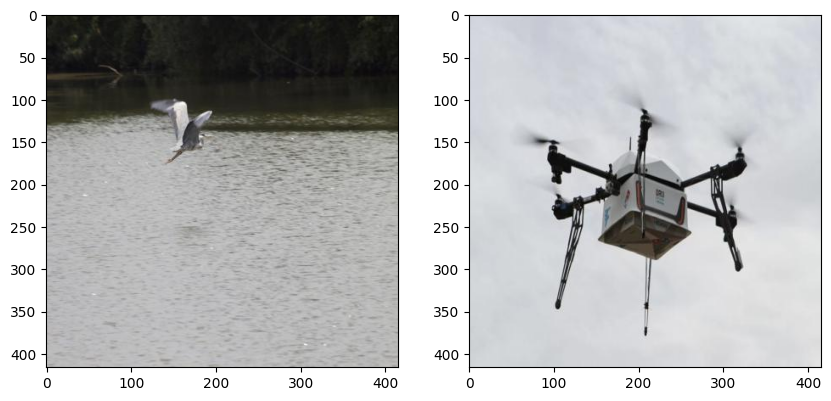

In [89]:
bird = os.listdir('./Data/train/bird')[5]
drone = os.listdir('./Data/train/drone')[5]
ax = plt.figure(figsize=(10,8))
ax.add_subplot(1,2,1)
plt.imshow(plt.imread(f'./Data/train/bird/{bird}'))
ax.add_subplot(1,2,2)
plt.imshow(plt.imread(f'./Data/train/drone/{drone}'))

## Preprocessing

In [119]:
# resizing and normalizing and data Augumentation
target_size = (224,224)
batch_size = 32
train_gen = ImageDataGenerator(rescale=1./225,
                              rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')
test_gen = ImageDataGenerator(rescale=1./255)

# making batches
train_generator = train_gen.flow_from_directory('./Data/train',
                                                target_size = target_size,
                                                batch_size=batch_size,
                                                class_mode='binary')

valid_generator = test_gen.flow_from_directory('./Data/valid',
                                               target_size = target_size,
                                               batch_size=batch_size,
                                               class_mode='binary')

test_generator = test_gen.flow_from_directory('./Data/test',
                                              target_size = target_size,
                                              batch_size=batch_size,
                                              class_mode='binary')

Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [93]:
# shape of a single bacth
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32,))

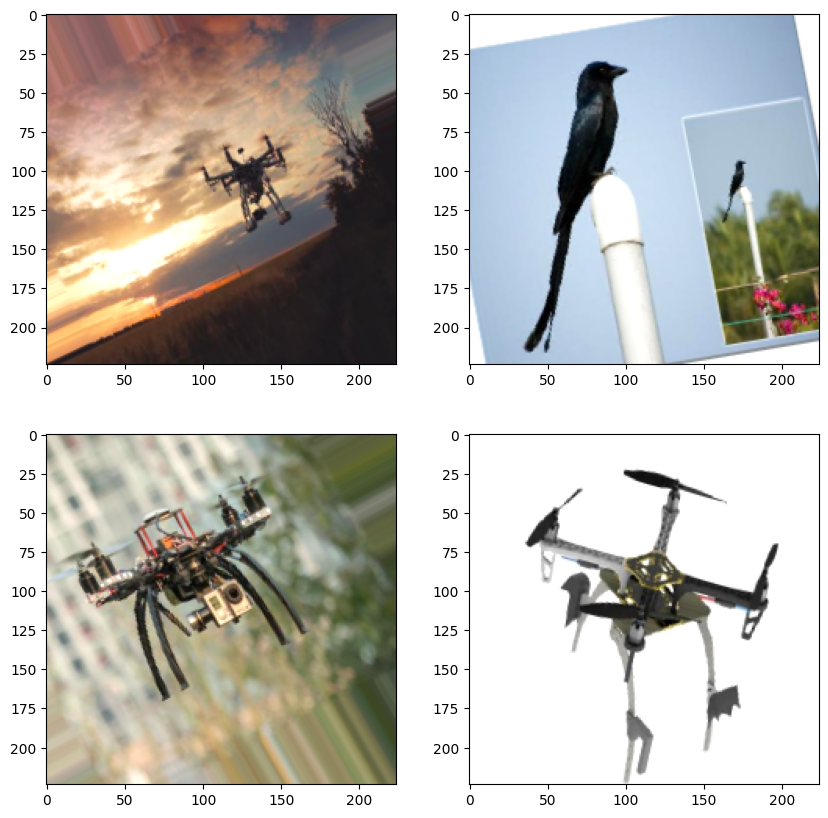

In [120]:
for x , y in train_generator:
  tst = x
  tst_label = y
  break
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.flatten()
for i in range(4):
  ax[i].imshow(tst[i])

## CNN Models

In [96]:
# a simple cnn network
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [97]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       186,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,017 (804.75 KB)

 Trainable params: 206,017 (804.75 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
# compiling and training
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(train_generator,
          validation_data=valid_generator,
          epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 421ms/step - accuracy: 0.8230 - loss: 0.4099 - val_accuracy: 0.7919 - val_loss: 0.4820
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 380ms/step - accuracy: 0.8166 - loss: 0.4017 - val_accuracy: 0.7579 - val_loss: 0.5559
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step - accuracy: 0.8097 - loss: 0.4063 - val_accuracy: 0.8077 - val_loss: 0.4637
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.8399 - loss: 0.3672 - val_accuracy: 0.8077 - val_loss: 0.4824
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 379ms/step - accuracy: 0.8254 - loss: 0.3957 - val_accuracy: 0.7557 - val_loss: 0.5796
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 397ms/step - accuracy: 0.8188 - loss: 0.3914 - val_accuracy: 0.8258 - val_loss: 0.4330
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - accuracy: 0.8530 - loss: 0.3362 - val_accuracy: 0.8303 - val_loss: 0.4173
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - accuracy: 0.8391 - loss: 0.3569 - val_accu

In [122]:
# Model evaluation
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.8330 - loss: 0.3523
Loss: 0.3401866555213928
Accuracy: 0.8558139801025391


In [106]:
def test_model(model):
  # testing the model
  for x , y in train_generator:
    tst = x
    tst_label = y
    break

  preds = model.predict_on_batch(tst)

  print(f'accuracy score: {accuracy_score(preds.round(), tst_label)}')
  print(classification_report(preds.round(), tst_label))
  disp = ConfusionMatrixDisplay(confusion_matrix(preds.round(), tst_label))
  disp.plot()
  plt.show()

accuracy score: 0.875
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        16
         1.0       0.88      0.88      0.88        16

    accuracy                           0.88        32
   macro avg       0.88      0.88      0.88        32
weighted avg       0.88      0.88      0.88        32



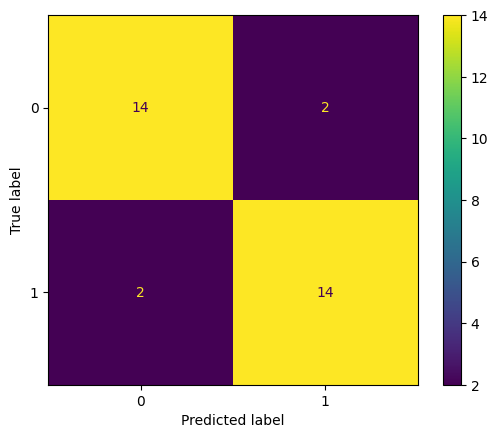

In [123]:
test_model(model)

In [112]:
# Model 2
model2 = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32,kernel_size=(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2,2),
    Conv2D(64,kernel_size=(3,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.25),
    Dense(1,activation='sigmoid')
])

In [113]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       186,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,401 (806.25 KB)

 Trainable params: 206,209 (805.50 KB)

 Non-trainable params: 192 (768.00 B)

In [124]:
# Compiling and training model2
model2.compile(optimizer='adam',
               loss = 'binary_crossentropy',
               metrics=['accuracy'])
model2.fit(train_generator,
           validation_data = valid_generator,
           epochs = 10)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 40s 430ms/step - accuracy: 0.6727 - loss: 5.3793 - val_accuracy: 0.5520 - val_loss: 3.5036
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.7292 - loss: 1.8929 - val_accuracy: 0.7014 - val_loss: 2.1465
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 401ms/step - accuracy: 0.7518 - loss: 1.5679 - val_accuracy: 0.7195 - val_loss: 2.2376
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 388ms/step - accuracy: 0.7608 - loss: 1.2393 - val_accuracy: 0.6018 - val_loss: 2.4383
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.7434 - loss: 1.3194 - val_accuracy: 0.7466 - val_loss: 1.2109
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 395ms/step - accuracy: 0.7605 - loss: 1.0702 - val_accuracy: 0.7624 - val_loss: 0.9298
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 384ms/step - accuracy: 0.7840 - loss: 0.8844 - val_accuracy: 0.6357 - val_loss: 1.9741
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.7870 - loss: 0.7829 - val_accu

In [126]:
# Evaluation
loss , accuray = model2.evaluate(test_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuray}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7009 - loss: 1.3578
Loss: 1.2084952592849731
Accuracy: 0.7255814075469971


accuracy score: 0.59375
              precision    recall  f1-score   support

         0.0       0.77      0.50      0.61        20
         1.0       0.47      0.75      0.58        12

    accuracy                           0.59        32
   macro avg       0.62      0.62      0.59        32
weighted avg       0.66      0.59      0.60        32



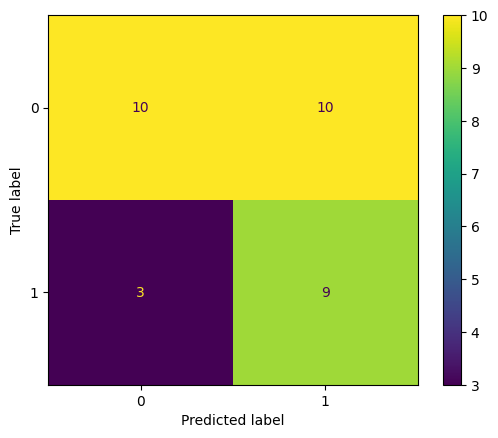

In [127]:
# Test
test_model(model2)

* Model1 has performed better than model2

## Transfer Learning using EfficientNetV2B0

In [128]:
from tensorflow.keras.applications import EfficientNetV2B0

In [ ]:
base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classifier_activation="sigmoid",
    include_preprocessing=False,
    name="efficientnetv2-b0",
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#total layers in the pretrained model
base_model.layers.__len__()

268

In [ ]:
base_model.trainable = False #for converging the model

inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)

outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model3 = tf.keras.Model(inputs, outputs)

In [ ]:
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 1280)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
model3.compile(optimizer='adam',
               loss = 'binary_crossentropy',
               metrics=['accuracy'])

model3.fit(train_generator,
           validation_data = valid_generator,
           epochs = 10)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 76s 649ms/step - accuracy: 0.6775 - loss: 0.9669 - val_accuracy: 0.9457 - val_loss: 0.1708
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 394ms/step - accuracy: 0.8977 - loss: 0.2755 - val_accuracy: 0.9615 - val_loss: 0.1383
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 397ms/step - accuracy: 0.9164 - loss: 0.2256 - val_accuracy: 0.9548 - val_loss: 0.1340
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 392ms/step - accuracy: 0.9248 - loss: 0.1817 - val_accuracy: 0.9548 - val_loss: 0.1188
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 396ms/step - accuracy: 0.9431 - loss: 0.1447 - val_accuracy: 0.9593 - val_loss: 0.1137
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.9498 - loss: 0.1431 - val_accuracy: 0.9593 - val_loss: 0.1069
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 398ms/step - accuracy: 0.9464 - loss: 0.1419 - val_accuracy: 0.9638 - val_loss: 0.1031
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.9439 - loss: 0.1776 - val_accu

In [ ]:
# testing
preds = model3.predict_on_batch(tst)
accuracy_score(preds.round(), tst_label)

0.96875

### Fine tuning the model

In [ ]:
# Unfreeze the base model
base_model.trainable = True

model3.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model3.fit(train_generator,
           validation_data = valid_generator,
           epochs = 10)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:789: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


84/84 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - binary_accuracy: 0.8964 - loss: 0.3052 - val_binary_accuracy: 0.9367 - val_loss: 0.1662
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 419ms/step - binary_accuracy: 0.9191 - loss: 0.2160 - val_binary_accuracy: 0.9389 - val_loss: 0.1445
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 417ms/step - binary_accuracy: 0.9177 - loss: 0.1970 - val_binary_accuracy: 0.9480 - val_loss: 0.1217
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 419ms/step - binary_accuracy: 0.9140 - loss: 0.2326 - val_binary_accuracy: 0.9570 - val_loss: 0.0968
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 414ms/step - binary_accuracy: 0.9336 - loss: 0.1655 - val_binary_accuracy: 0.9570 - val_loss: 0.1060
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 409ms/step - binary_accuracy: 0.9462 - loss: 0.1493 - val_binary_accuracy: 0.9615 - val_loss: 0.0924
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 419ms/step - binary_accuracy: 0.9340 - loss: 0.2016 - val_binary_accuracy: 0.9706 - val_loss: 0.0807
Epoch 8/10
8

In [ ]:
# Testing
preds = model3.predict_on_batch(tst)
accuracy_score(preds.round(), tst_label)

1.0

# Areial object detection(YOLOv8)

In [13]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00


## importing libraries

In [14]:
import cv2
from ultralytics import YOLO
import matplotlib.patches as patches
import pandas as pd

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## reading data

In [15]:
# Downloading folder
gdown.download_folder(id="1VJEfmVM07BDwCyO6L3jPuDhUk3wkzW1U")

# unzipping files
unzip_files('./Dect_data/',['train.zip','valid.zip','test.zip'])

Retrieving folder contents


Processing file 14in50rdpakijgK9fg6Ny9-vGJuZG_Lry data.yaml
Processing file 1oS1ZDSe-BfWXOCR00q_qzgRFCxeTaqtt test.zip
Processing file 1qS7JEyRLZclM0DopA50ti09iMgX5DW9F train.zip
Processing file 1ZiKmrDPrtiKwputlifZcIWRkIIwjFlWm valid.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14in50rdpakijgK9fg6Ny9-vGJuZG_Lry
To: /content/Dect_data/data.yaml
100%|██████████| 298/298 [00:00<00:00, 115kB/s]
Downloading...
From: https://drive.google.com/uc?id=1oS1ZDSe-BfWXOCR00q_qzgRFCxeTaqtt
To: /content/Dect_data/test.zip
100%|██████████| 5.64M/5.64M [00:00<00:00, 59.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1qS7JEyRLZclM0DopA50ti09iMgX5DW9F
From (redirected): https://drive.google.com/uc?id=1qS7JEyRLZclM0DopA50ti09iMgX5DW9F&confirm=t&uuid=2a9801a1-a8d8-422a-b306-b76c06561d3c
To: /content/Dect_data/train.zip
100%|██████████| 68.3M/68.3M [00:01<00:00, 64.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZiKmrDPrtiKwputlifZcIWRkIIwjFlWm
To: /content/Dect_data/valid.zip
100%|██████████| 11.1M/11.1M [00:00<00:00, 25.0MB/s]
Download completed


train.zip extracted
valid.zip extracted
test.zip extracted


In [ ]:
count_files('./Dect_data/','train')
count_files('./Dect_data/','valid')
count_files('./Dect_data/','test')

Total files in train: 2
labels: 2728
images: 2728
----------
Total files in valid: 2
labels: 448
images: 448
----------
Total files in test: 2
labels: 224
images: 224
----------


In [129]:
# label format => <class_id> <x_center> <y_center> <width> <height>

In [16]:

def display_image_with_rectangle(images):
  classes = ['bird','drone']
  # Display the image
  fig, ax = plt.subplots(2,2,figsize=(10, 10))
  ax = ax.flatten()

  for i in range(4):
    img = plt.imread('./Dect_data/train/images/'+images[i])
    lbl = os.path.splitext(images[i])[0] + '.txt'

    with open('./Dect_data/train/labels/'+lbl ,'r') as f:
      label = f.read()
    class_id,cord = label.split()[0],label.split()[1:]
    cord = [float(i)*416 for i in cord]
    ax[i].imshow(img)

    # Define rectangle parameters: (x, y), width, height
    rect = patches.Rectangle(
        (cord[0]-cord[2]/2, cord[1]-cord[3]/2),   # (x, y) starting point (top-left corner)
        cord[2],         # width
        cord[3],         # height
        linewidth=2, # border thickness
        edgecolor='red', # border color
        facecolor='none' # transparent fill
    )

    # Add rectangle to the plot
    ax[i].add_patch(rect)
    # Add class label
    ax[i].text(cord[0]-cord[2]/2, cord[1]-cord[3]/2 , classes[int(class_id)],
            color='yellow', fontsize=10, backgroundcolor='black')

  plt.show()


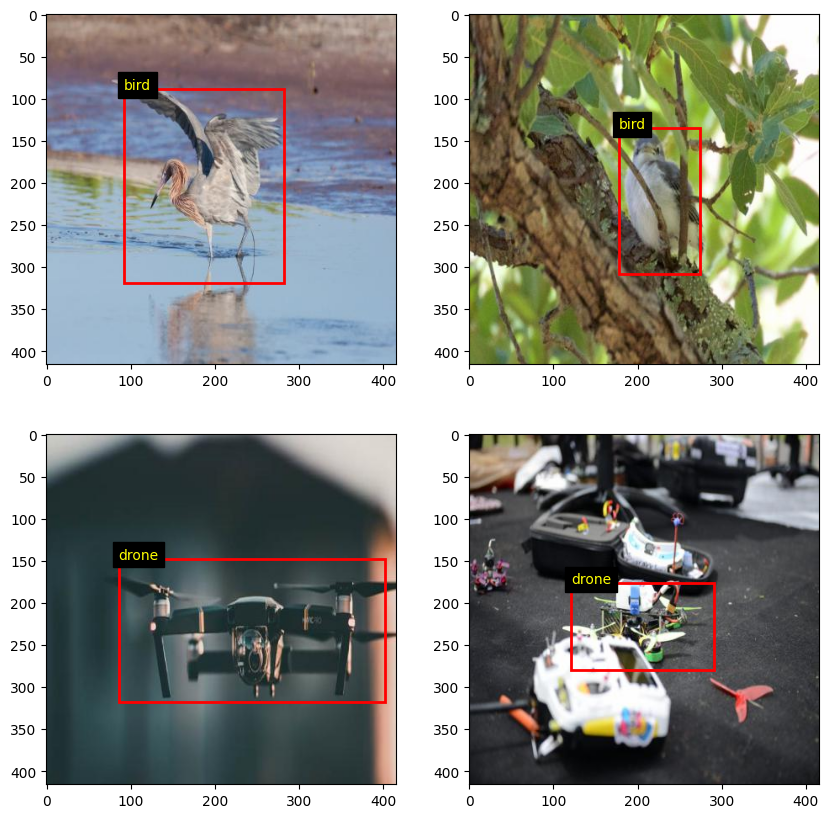

In [18]:
dect_imgs = os.listdir('./Dect_data/train/images')[:4]
display_image_with_rectangle(dect_imgs)

## Training YOLOv8 model

In [24]:
# Load a model
yolo_model = YOLO("yolov8n.pt")

# Train the model
results = yolo_model.train(data="Dect_data/data.yaml", epochs=5, imgsz=416, device="cpu")

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Dect_data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

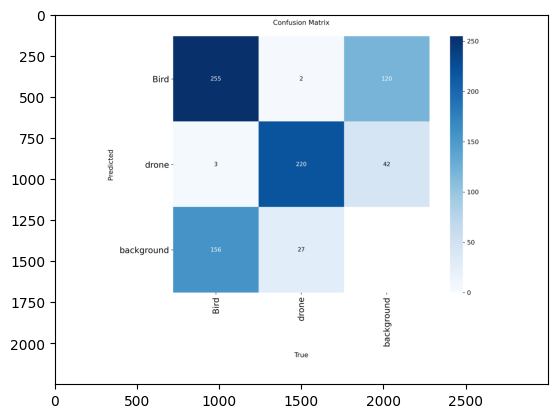

In [132]:
# confusion matrix
plt.imshow(plt.imread('./runs/detect/train/confusion_matrix.png'))

In [133]:
# Epochs history
pd.read_csv('./runs/detect/train/results.csv')

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,53.5982,1.40667,2.34560,1.46554,0.48631,0.36603,0.36994,0.16265,1.76881,2.49993,1.82043,0.000552,0.000552,0.000552
1,2,86.0181,1.61785,1.97919,1.60499,0.34573,0.39904,0.25623,0.10574,1.93162,2.74014,2.02986,0.000998,0.000998,0.000998
2,3,115.3000,1.65867,1.86629,1.65984,0.52413,0.36979,0.36658,0.17638,1.87897,2.31542,1.93702,0.001334,0.001334,0.001334
3,4,145.1230,1.59742,1.69163,1.61107,0.55762,0.43677,0.45135,0.21840,1.73885,1.86002,1.72562,0.001172,0.001172,0.001172
4,5,174.2940,1.49880,1.48206,1.52368,0.74202,0.52449,0.61606,0.33524,1.59636,1.46715,1.59062,0.001007,0.001007,0.001007
5,6,203.2900,1.44630,1.34997,1.47096,0.68784,0.60579,0.65343,0.37769,1.48263,1.39970,1.51818,0.000842,0.000842,0.000842
6,7,232.2780,1.36395,1.24677,1.42127,0.77523,0.61237,0.68850,0.41877,1.41021,1.20292,1.42721,0.000677,0.000677,0.000677
7,8,262.3490,1.28966,1.10088,1.36976,0.74634,0.67329,0.73632,0.43746,1.39455,1.15390,1.42900,0.000512,0.000512,0.000512
8,9,291.6540,1.22567,1.02487,1.32585,0.81441,0.68923,0.75049,0.47215,1.33117,1.04258,1.39556,0.000347,0.000347,0.000347
9,10,320.8120,1.16292,0.94009,1.27421,0.84525,0.71525,0.77690,0.49164,1.28180,0.98545,1.35594,0.000182,0.000182,0.000182


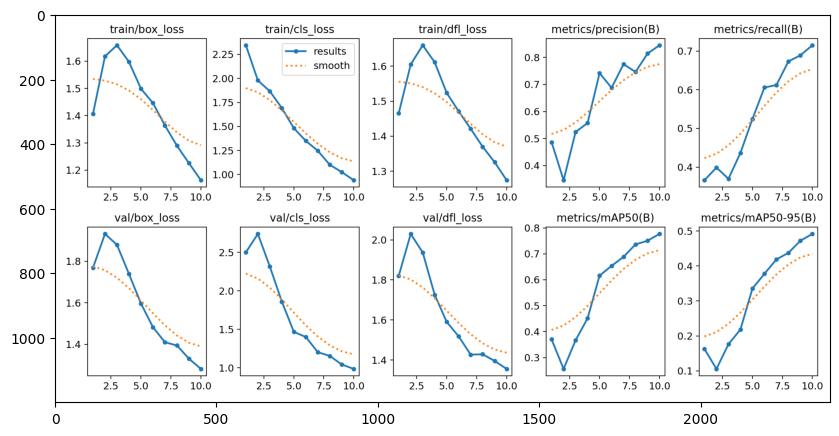

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread('./runs/detect/train/results.png'))

In [60]:
pred=yolo_model.predict('./Dect_data/test/images/'+os.listdir('./Dect_data/test/images')[215],
                   conf = 0.25,save=False,save_txt=False, save_conf=False)


image 1/1 /content/Dect_data/test/images/pic_001_jpg.rf.3071298dcf17b08d42895e0d803a9a92.jpg: 416x416 1 drone, 114.5ms
Speed: 1.8ms preprocess, 114.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
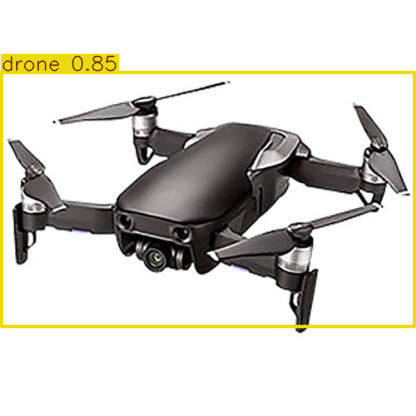

In [61]:
pred[0].plot()

In [62]:
yolo_model.save('bird_drone.pt')

#Thankyou!